# Explorative Datenanalyse
Im Folgenden werden die gemessenen Index-Werte der Brokkoli analysiert. Im Vorfeld wurden diese bereits innerhalb der Voronoi-Zellen segmentiert, das heisst Es werden nur noch die Pixel gewertet, welche zum Brokkoli gehören, ohne die Erde darum zu berücksichtigen.

In [2]:
#%reset

# Datenabfrage von Server-DB
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of dates to be considered
dates = ['2019-04-18', '2019-04-25', '2019-05-01', '2019-05-09']

# Verbindungsaufbau
server = 'deepbroccoliserver.database.windows.net'
database = 'DeepBroccoliDatabase'
username = 'ntb'
password = 'brokkoli_2019'
driver= '{SQL Server}'
cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)

# Abfrage definieren und ausführen: Alle Brokkoli mit allen dazugehörigen Messwerten 
SQL_Query = pd.read_sql_query('''
select dbo.broccoli.id, dbo.broccolivalues.timestamp, dbo.broccoli.lat, dbo.broccoli.long, 
dbo.broccolivalues.pixelCount, dbo.broccolivalues.maxNDVI, dbo.broccolivalues.minNDVI,
dbo.broccolivalues.meanNDVI, dbo.broccolivalues.medianNDVI, dbo.broccolivalues.maxNDRE, dbo.broccolivalues.minNDRE,
dbo.broccolivalues.meanNDRE, dbo.broccolivalues.medianNDRE
from dbo.broccoli inner join dbo.broccolivalues on dbo.broccoli.id = dbo.broccolivalues.id''', cnxn)
broccoli_data = pd.DataFrame(SQL_Query)

# Describe: Erste Übersicht
#broccoli_data = broccoli_data.drop(broccoli_data.columns[3], axis=1)
broccoli_data.head()

,id,timestamp,lat,long,pixelCount,maxNDVI,minNDVI,meanNDVI,medianNDVI,maxNDRE,minNDRE,meanNDRE,medianNDRE
0,1,2019-04-18,47.217185,9.492887,134,0.788905,0.470976,0.614020,0.614058,0.177638,-0.060647,0.085250,0.085514
1,1,2019-04-25,47.217185,9.492887,28,0.631827,0.399177,0.487436,0.470969,0.258980,-0.084967,0.120464,0.118629
2,1,2019-05-01,47.217185,9.492887,70,0.689316,0.400272,0.546891,0.556947,0.252909,0.015296,0.135502,0.135796
3,1,2019-05-09,47.217185,9.492887,269,0.788905,0.392496,0.520131,0.473748,0.177638,-0.060647,0.070062,0.066007
4,2,2019-04-18,47.217187,9.492902,128,0.822176,0.473620,0.673673,0.699712,0.136989,-0.075157,0.081806,0.087695


## Analyse der Pixel-Menge (pixelCount)
Als erstes werden die Anzahl Pixel, die nach der Segmentierung eine Brokkoli-Pflanze darstellen, analysiert. Hier wird versucht, inkorrekt oders seltsam segmentierte Daten zu finden.

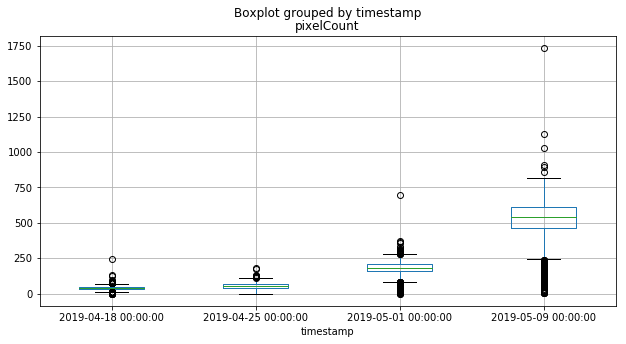

In [3]:
# Boxplot der Pixelanzahl gruppiert nach Datum
broccoli_data.boxplot(by="timestamp", column=['pixelCount'], figsize=(10,5))

In [4]:
# Ausgabe der Anzahl Datenpunkte mit pixelCount in einem bestimmten Quantilsbereich pro Datum

for date in dates:    
    # Listen mit Pflanzen mit pixelCount > 98%-Quantil bzw. < 2%-Quantil erstellen
    broccoli_data_byDate = broccoli_data[broccoli_data.timestamp == date]
    
    under02Quant = broccoli_data_byDate[broccoli_data_byDate.pixelCount < 
                                        broccoli_data_byDate['pixelCount'].quantile(0.02)]
    over98Quant = broccoli_data_byDate[broccoli_data_byDate.pixelCount > 
                                       broccoli_data_byDate['pixelCount'].quantile(0.98)]
    
    # CSV mit IDs der Pflanzen mit pixelCount <2%-Quantil oder >98%-Quantil erstellen
    np.savetxt("pixelCount_under02Quant_IDs_" + date + ".csv", under02Quant[['id', 'pixelCount']], 
               header="id;pixelCount", delimiter=";", fmt="%d")    
    np.savetxt("pixelCount_over98Quant_IDs_" + date + ".csv", over98Quant[['id', 'pixelCount']], 
               header="id;pixelCount", delimiter=";", fmt="%d")

    # HTML mit den Segmentierungs-Bildern erstellen
    strHtml = ""
    for index, row in pd.concat([under02Quant, over98Quant]).iterrows():
        strId = str(row["id"])
        strHtml += "<p>#" + strId + " ; pixelCount = " + str(row["pixelCount"]) + "</p>\n"
        strHtml += "<img src=\"\\\\fs004\\ice\\Lehre\\Bachelorarbeiten\\2019\\Pflanzen\\Drohnenaufnahmen\\" \
        + (str(date)).replace('-', '') + "\\report\\images\\" + strId + "\\ndvi_ndre_cutout_comparision_" + strId + ".png\">\n"
       
    
    html = open("pixelCount_NotableImages_" + date + ".html", 'w')
    html.write(strHtml)
    
    # Ausgabe der Anzahlen
    nofUnder02Quant = len(under02Quant)
    nofOver98Quant = len(over98Quant)
    
    print(date + ":: <02%: " + str(nofUnder02Quant) + " | >98%; " + str(nofOver98Quant))

2019-04-18:: <02%: 52 | >98%; 51
2019-04-25:: <02%: 53 | >98%; 52
2019-05-01:: <02%: 54 | >98%; 51
2019-05-09:: <02%: 54 | >98%; 53


### Zwischenfazit pixelCount, Stand 16.05.2019
Da im Boxplot ersichtlich ist, dass es einige Ausreisser gibt, werden die Datensätze mit pixelCount ausserhalb der 2%- bzw. 98%-Quantile genauer untersucht (Muss allenfalls auf z.B. 5%, 95% ausgeweitet werden). Dazu werden je Datum eine CSV- und eine HTML-Datei erstellt, mit den IDs, dem pixelCount und den Vergleichsbildern der Segmentierung (im HTML). Diese müssen manuell kontrolliert werden, danach können Datensätze entweder gelöscht oder angepasst werden.

## Analyse der NDVI und NDRE Messwerte
Im Folgenden werden die aggregierten NDVI und NDRE Werte der segmentierten Bilder analysiert. Es werden Ausreisser und auffällige Messwerte gesucht, zeitliche Verläufe der Werte, und Abhängigkeiten zwischen den Indizes. Ein Plot mit y-Achse = NDRE und x-Achse = NDVI würde die Grundlage für die Berechnung des CCCI bilden.

## NDVI

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CF299D1048>,
      dtype=object)

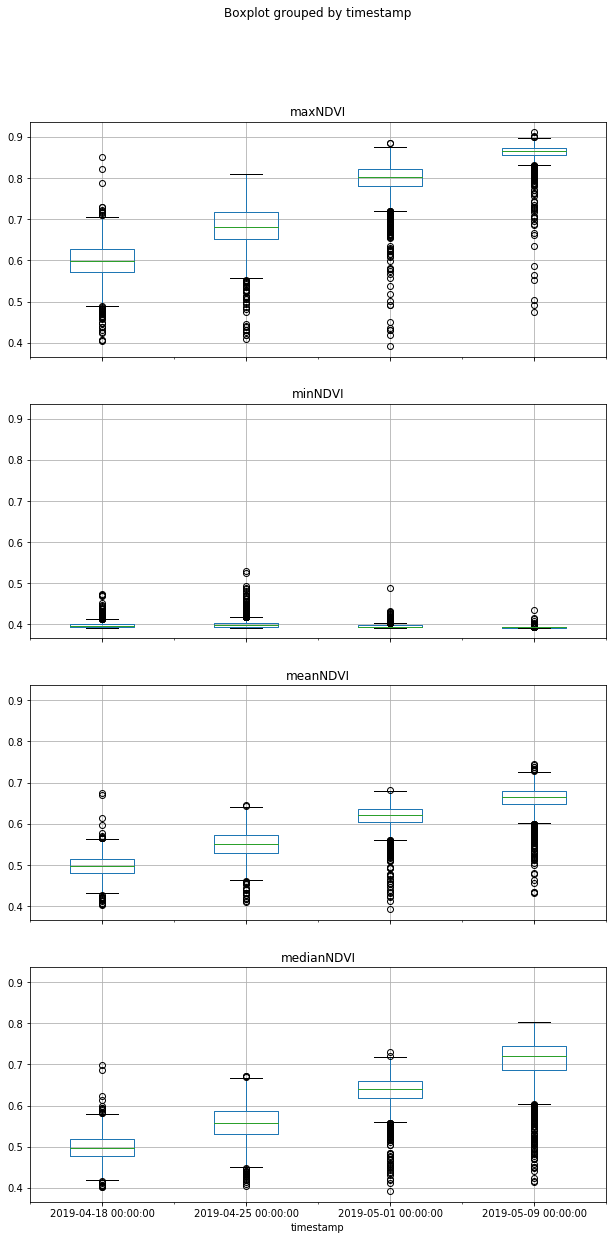

In [5]:
# Boxplot der NDVI-Werte gruppiert nach Datum
columns = ['maxNDVI', 'minNDVI', 'meanNDVI', 'medianNDVI']
broccoli_data.boxplot(by="timestamp", column=columns, layout=(len(dates), 1), 
                                                 figsize=(10,len(dates)*5))

### Zwischenfazit NDVI, Stand 16.05.2019
Es ist ersichtlich, dass die Max-, Durchschnitts- und Median-Werte des NDVI mit der Zeit deutlich steigen. Die Min-Werte bleiben etwa gleich, dies liegt entweder an der Segmentierung oder bildet einfach eine gewisse Untergrenze bei den Pflanzen. 

## NDRE

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CF29F4CCF8>,
      dtype=object)

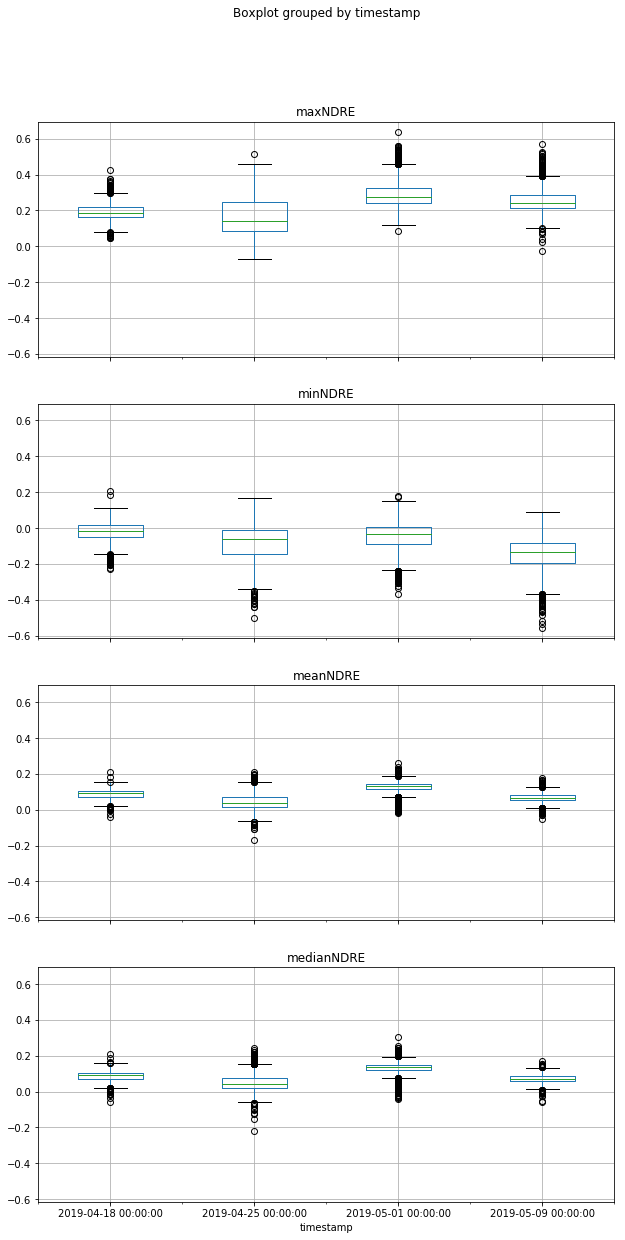

In [6]:
# Boxplot der NDRE-Werte gruppiert nach Datum
columns = ['maxNDRE', 'minNDRE', 'meanNDRE', 'medianNDRE']
broccoli_data[broccoli_data.columns[1:]].boxplot(by="timestamp", column=columns, layout=(len(dates), 1), 
                                                 figsize=(10,len(dates)*5))